In [19]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from keras.layers import LSTM

In [20]:
#df = pd.read_csv('bank.csv', sep=',', na_values='.')
df = pd.read_csv('bank.csv')
#edu는   
#basic.4y 0
#high.school 1
#basic.6y 2
#professional.course 3
#basic.9y 4
#university.degree 5
# unknown 6
#illiterate 7


 


In [21]:
df.corr()

,age,education,housing,loan,duration,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
age,1.000000,-0.075645,0.001855,-0.010697,0.006673,-0.050516,-0.037416,0.128179,-0.036070,-0.063312,0.049509
education,-0.075645,1.000000,0.017641,0.005725,-0.013618,-0.009755,-0.046171,0.056156,-0.002449,-0.003759,0.027649
housing,0.001855,0.017641,1.000000,0.048100,-0.005556,-0.059090,-0.077684,-0.036028,-0.058593,-0.044660,0.012092
loan,-0.010697,0.005725,0.048100,1.000000,0.006590,-0.000403,-0.003943,-0.019042,-0.002468,0.003246,-0.004687
duration,0.006673,-0.013618,-0.005556,0.006590,1.000000,-0.024539,0.011985,-0.008426,-0.030549,-0.042165,0.392781
emp.var.rate,-0.050516,-0.009755,-0.059090,-0.000403,-0.024539,1.000000,0.765002,0.142321,0.969109,0.899383,-0.309622
cons.price.idx,-0.037416,-0.046171,-0.077684,-0.003943,0.011985,0.765002,1.000000,0.015546,0.664338,0.484643,-0.130693
cons.conf.idx,0.128179,0.056156,-0.036028,-0.019042,-0.008426,0.142321,0.015546,1.000000,0.229120,0.061613,0.066306
euribor3m,-0.036070,-0.002449,-0.058593,-0.002468,-0.030549,0.969109,0.664338,0.229120,1.000000,0.944819,-0.320579
nr.employed,-0.063312,-0.003759,-0.044660,0.003246,-0.042165,0.899383,0.484643,0.061613,0.944819,1.000000,-0.368170


In [22]:
fea=[]

In [23]:
for h in ['emp.var.rate','cons.price.idx','cons.conf.idx','euribor3m','nr.employed']:
    fea.append(tf.feature_column.numeric_column(h))

age=tf.feature_column.numeric_column("age")
age_b=tf.feature_column.bucketized_column(age,boundaries=[10,20,30,40,50,60,70])
fea.append(age_b)

df["education"]=df["education"].apply(str)
education=tf.feature_column.categorical_column_with_vocabulary_list('education',['0','1','2','3','4','5','6','7'])
education_o=tf.feature_column.indicator_column(education)
fea.append(education_o)

df["housing"]=df["housing"].apply(str)
housing=tf.feature_column.categorical_column_with_vocabulary_list('housing',['0','1'])
housing_o=tf.feature_column.indicator_column(housing)
fea.append(housing_o)

df["loan"]=df["loan"].apply(str)
loan=tf.feature_column.categorical_column_with_vocabulary_list('loan',['0','1'])
loan_o=tf.feature_column.indicator_column(loan)
fea.append(loan_o)

duration=tf.feature_column.numeric_column("duration")
duration_b=tf.feature_column.bucketized_column(duration,boundaries=[50,100,150,200,250,300,400,500,800,1000])
fea.append(duration_b)




In [24]:
fea

[NumericColumn(key='emp.var.rate', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='cons.price.idx', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='cons.conf.idx', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='euribor3m', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='nr.employed', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 BucketizedColumn(source_column=NumericColumn(key='age', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), boundaries=(10, 20, 30, 40, 50, 60, 70)),
 IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='education', vocabulary_list=('0', '1', '2', '3', '4', '5', '6', '7'), dtype=tf.string, default_value=-1, num_oov_buckets=0)),
 IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='housing', vocabulary_list=('0

In [25]:
def create_dataset(dataframe,batch_size=32):
    dataframe=dataframe.copy()
    labels=dataframe.pop('y')
    return tf.data.Dataset.from_tensor_slices((dict(dataframe),labels)).shuffle(buffer_size=len(dataframe)).batch(batch_size)

In [26]:
train,test=train_test_split(df,test_size=0.2,random_state=42)
train_1=create_dataset(train)
test_1=create_dataset(test)

In [27]:
model=tf.keras.models.Sequential([
    tf.keras.layers.DenseFeatures(feature_columns=fea),
    tf.keras.layers.Dense(units=128,activation='relu'),
    tf.keras.layers.Dropout(rate=0.3),
    tf.keras.layers.Dense(units=128,activation='relu'),
    tf.keras.layers.Dense(units=1,activation='sigmoid')
])

In [28]:
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
history=model.fit(train_1,validation_data=test_1,epochs=10,use_multiprocessing=True)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 1/10
796/796 [==============================] - 8s 10ms/step - loss: 8.8626 - accuracy: 0.7777 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
796/796 [==============================] - 6s 7ms/step - loss: 1.2794 - accuracy: 0.7922 - val_loss: 0.5453 - val_accuracy: 0.8704
Epoch 3/10
796/796 [==============================] - 6s 8ms/step - loss: 0.5064 - accuracy: 0.8490 - val_loss: 0.3847 - val_accuracy: 0.8704
Epoch 4/10
796/796 [==============================] - 6s 7ms/step - loss:

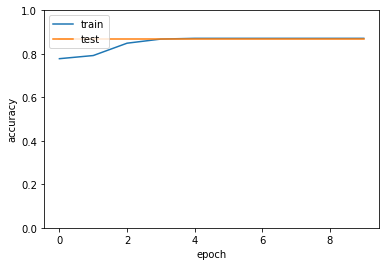

In [29]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim((0,1))
plt.legend(['train','test'],loc='upper left')
plt.show()